In [47]:
!pip install bert-for-tf2
!pip install sentencepiece

### IMPORT

In [48]:
import pandas as pd
import numpy as np
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from google.colab import drive
import tensorflow_hub as hub
import re
from tensorflow.keras import layers
import bert
import random
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
import pickle
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [49]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
data =pickle.load(open('/content/drive/My Drive/NewsClassifier/News_data_with_length','rb'))
data.head()

,category,headline,authors,short_description,headline_length,short_description_length,information,info_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,She left her husband. He killed their children...,14,13,There Were 2 Mass Shootings In Texas Last Week...,27
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,Of course it has a song.,14,6,Will Smith Joins Diplo And Nicky Jam For The 2...,20
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,The actor and his longtime girlfriend Anna Ebe...,10,15,Hugh Grant Marries For The First Time At Age 5...,25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,The actor gives Dems an ass-kicking for not fi...,11,14,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,25
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,"The ""Dietland"" actress said using the bags is ...",13,13,Julianna Margulies Uses Donald Trump Poop Bags...,26


In [51]:
data = data[['category','authors']]
data.head()

,category,authors
0,CRIME,Melissa Jeltsen
1,ENTERTAINMENT,Andy McDonald
2,ENTERTAINMENT,Ron Dicker
3,ENTERTAINMENT,Ron Dicker
4,ENTERTAINMENT,Ron Dicker


In [0]:
def clean_text(text):
  text = re.sub(r"@[A-Za-z0-9]+"," ",text) # remove @usernames
  text = re.sub(r"https?://[A-Za-z0-9./]+"," ",text) #remove https links
  text = re.sub(r"[^A-Za-z.!?']"," ",text)  # keep only letters and few punctuations
  text = re.sub(r" +"," ",text) # remove extra spaces
  text = text.lower()
  return text

In [0]:
def remove_stop(msg):
    nopunc = msg.split()
    clean = [word for word in nopunc if word.lower() not in stopwords.words('english')]
    clean = " ".join(clean)
    return clean

In [54]:
# data['processed_info'] = data.authors.apply(clean_text)

AttributeError: ignored

In [0]:
# data['processed_info'] = data.processed_info.apply(remove_stop)

In [0]:
X,y = data.authors.values, data.category.values

In [0]:
pickle.dump((X,y),open('/content/drive/My Drive/NewsClassifier/stop_removed_info_and_label','wb'))

#### USING BERT TOKENIZER

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
tag2idx ={}
c=0
for tag in set(y):
    tag2idx[tag] = c
    c+=1
idx2tag = { v:k for k,v in tag2idx.items()}

In [0]:
 data_X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)) for sentence in X]
 data_y = [tag2idx[tag] for tag in y]

### SPLITTING OF SKEWED DATA

In [61]:
skf = StratifiedShuffleSplit(n_splits=2,test_size=0.2)
skf.get_n_splits(data_X,data_y )

2

In [0]:
X_array = np.array(data_X)
y_array = np.array(data_y)

In [63]:
for train_index,test_index in skf.split(data_X,data_y):   ## Splitting into train and test_set
  print("TRAIN:", train_index, "TEST:", test_index)
  #print(len(train_index))
  X_train,X_test = X_array[train_index], X_array[test_index]
  y_train,y_test = y_array[train_index], y_array[test_index]


TRAIN: [ 75355  53429  15650 ... 186334  75425  71421] TEST: [ 19575 105103  79293 ...  78207 111108 181699]
TRAIN: [ 73904 115975 137276 ... 122184  18976 186950] TEST: [ 63077  42256 172105 ...  36147 174681 158460]


###### PADDING the entire data and truncating to length 20

In [0]:
X_train =tf.keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)
X_test =tf.keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)

In [65]:
print(X_train.shape)
print(X_test.shape)

(157112, 20)
(39278, 20)


In [66]:
from sklearn.model_selection import train_test_split  ### Splitting into test and cross_validation set
X_val, X_test, y_val, y_test = train_test_split(
     X_test, y_test, test_size=0.5, random_state=42)
print(X_val.shape)
print(X_test.shape)

(19639, 20)
(19639, 20)


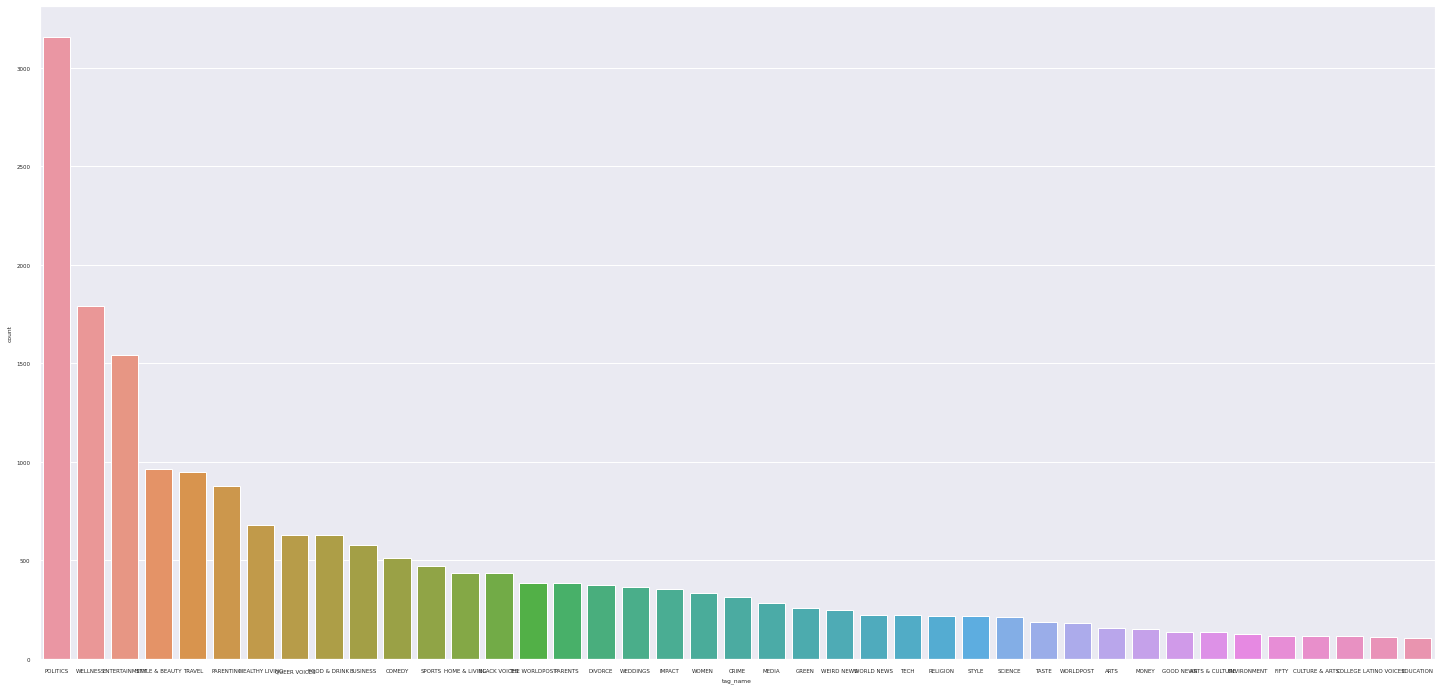

In [67]:
df = pd.DataFrame(y_test,columns=['targets'])             
index = pd.DataFrame(df.targets.value_counts().index)
counts = pd.DataFrame(df.targets.value_counts().values)
concat_df = pd.concat([index,counts],axis=1)
concat_df.columns =['tag','count']
# concat_df.head(2)
labels = [idx2tag[idx] for idx in index]
def get_names(x):
  return idx2tag[x]
concat_df['tag_name'] = concat_df.tag.apply(get_names)
plt.figure(figsize=(25,12))
sns.set(font_scale=0.5)
sns.barplot(x="tag_name",y="count",data=concat_df)       ### Distribution of classes in Training set

### MODEL 

In [0]:
V = len(tokenizer.vocab)
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(V, 64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])


#### Checkpoints

In [69]:
checkpoint_directory = "/content/drive/My Drive/NewsClassifier/LSTM/ckpts"
checkpoint = tf.train.Checkpoint(model=model) 
manager = tf.train.CheckpointManager(checkpoint,checkpoint_directory,max_to_keep=1)
if manager.latest_checkpoint:
  checkpoint.restore(manager.latest_checkpoint) #Restores this Checkpoint and any objects it depends on.
  print("Latest Checkpoint restored!! ") 

Latest Checkpoint restored!! 


### Train

In [70]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
num_epochs = 10
history = model.fit(X_train,y_train, epochs=num_epochs, verbose=2,batch_size=32,validation_data=(X_val,y_val))
manager.save()

Epoch 1/10
4910/4910 - 93s - loss: 1.8397 - sparse_categorical_accuracy: 0.5119 - val_loss: 1.5355 - val_sparse_categorical_accuracy: 0.5840
Epoch 2/10
4910/4910 - 93s - loss: 1.6146 - sparse_categorical_accuracy: 0.5651 - val_loss: 1.4806 - val_sparse_categorical_accuracy: 0.5959
Epoch 3/10
4910/4910 - 95s - loss: 1.5442 - sparse_categorical_accuracy: 0.5809 - val_loss: 1.4688 - val_sparse_categorical_accuracy: 0.6023
Epoch 4/10
4910/4910 - 94s - loss: 1.5033 - sparse_categorical_accuracy: 0.5903 - val_loss: 1.4560 - val_sparse_categorical_accuracy: 0.6050
Epoch 5/10
4910/4910 - 95s - loss: 1.4736 - sparse_categorical_accuracy: 0.5982 - val_loss: 1.4509 - val_sparse_categorical_accuracy: 0.6060
Epoch 6/10
4910/4910 - 95s - loss: 1.4492 - sparse_categorical_accuracy: 0.6035 - val_loss: 1.4516 - val_sparse_categorical_accuracy: 0.6069
Epoch 7/10
4910/4910 - 96s - loss: 1.4330 - sparse_categorical_accuracy: 0.6056 - val_loss: 1.4457 - val_sparse_categorical_accuracy: 0.6093
Epoch 8/10
49

'/content/drive/My Drive/NewsClassifier/LSTM/ckpts/ckpt-3'

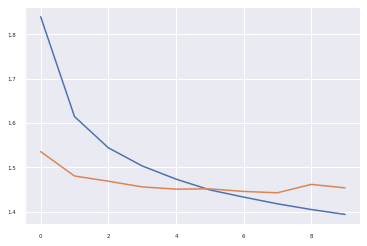

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

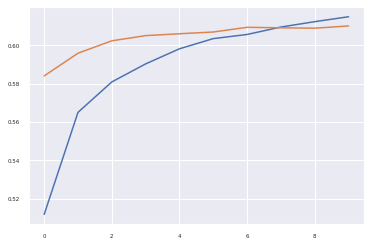

In [72]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

In [73]:
results = model.evaluate(X_test,y_test)
print(results)

614/614 [==============================] - 2s 3ms/step - loss: 1.4918 - sparse_categorical_accuracy: 0.5987
[1.4918235540390015, 0.5987066626548767]
